## Data Preparation

In [1]:
import numpy as np
import os
import rasterio
from sklearn.model_selection import train_test_split
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

def read_tiff(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()
        transform = src.transform
        crs = src.crs
    return image, transform, crs

def create_patches(image, patch_size):
    patches = []
    if len(image.shape) == 3:  # For 3D images (height, width, channels)
        for i in range(0, image.shape[0] - patch_size + 1, patch_size):
            for j in range(0, image.shape[1] - patch_size + 1, patch_size):
                patch = image[i:i + patch_size, j:j + patch_size, :]
                patches.append(patch)
    elif len(image.shape) == 2:  # For 2D images (height, width)
        for i in range(0, image.shape[0] - patch_size + 1, patch_size):
            for j in range(0, image.shape[1] - patch_size + 1, patch_size):
                patch = image[i:i + patch_size, j:j + patch_size]
                patches.append(patch)
    return np.array(patches)


## Loading and Preparing the Data

In [2]:
# Load images
landsat_image, landsat_transform, landsat_crs = read_tiff('Images/Landsat_2021.tif')
reference_image, reference_transform, reference_crs = read_tiff('Reference_data.tif')

# Transpose Landsat image
landsat_image = np.transpose(landsat_image, (1, 2, 0))  # From (channels, height, width) to (height, width, channels)

# Reshape the reference image to add a singleton dimension
reference_image = reference_image.squeeze()  # Remove the singleton dimension first if it exists
reference_image = reference_image[:, :, np.newaxis]  # Add singleton dimension to make it (height, width, 1)

# Print shapes to verify
print(f"Landsat image shape: {landsat_image.shape}")
print(f"Reference image shape: {reference_image.shape}")

# Create patches
patch_size = 256
landsat_patches = create_patches(landsat_image, patch_size)
reference_patches = create_patches(reference_image, patch_size)

print(f"Number of Landsat patches: {len(landsat_patches)}")
print(f"Number of reference patches: {len(reference_patches)}")


Landsat image shape: (7046, 7206, 5)
Reference image shape: (7046, 7206, 1)
Number of Landsat patches: 756
Number of reference patches: 756


## Splitting the Data

In [8]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(landsat_patches, reference_patches, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 529
Validation set size: 113
Test set size: 114


## Saving Patches to Disk

In [9]:
# Save patches to disk as TIFF files
def save_patches_as_tiff(patches, directory, prefix, transform, crs):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for idx, patch in enumerate(patches):
        patch_path = os.path.join(directory, f"{prefix}_{idx + 1}.tif")
        height, width = patch.shape[0], patch.shape[1]
        if len(patch.shape) == 3:  # Multichannel image
            count = patch.shape[2]
        else:  # Single channel image
            count = 1
            patch = np.expand_dims(patch, axis=2)  # Add channel dimension
        new_transform = from_origin(transform.c * idx, transform.f * idx, transform.a, transform.e)
        with rasterio.open(
            patch_path, 'w', driver='GTiff', height=height, width=width, count=count,
            dtype=patch.dtype, crs=crs, transform=new_transform
        ) as dst:
            for band in range(count):
                dst.write(patch[:, :, band], band + 1)

landsat_train_dir = 'landsat_patches3/train'
landsat_val_dir = 'landsat_patches3/val'
landsat_test_dir = 'landsat_patches3/test'
reference_train_dir = 'reference_patches3/train'
reference_val_dir = 'reference_patches3/val'
reference_test_dir = 'reference_patches3/test'

save_patches_as_tiff(X_train, landsat_train_dir, 'pl', landsat_transform, landsat_crs)
save_patches_as_tiff(X_val, landsat_val_dir, 'pl', landsat_transform, landsat_crs)
save_patches_as_tiff(X_test, landsat_test_dir, 'pl', landsat_transform, landsat_crs)
save_patches_as_tiff(y_train, reference_train_dir, 'pr', reference_transform, reference_crs)
save_patches_as_tiff(y_val, reference_val_dir, 'pr', reference_transform, reference_crs)
save_patches_as_tiff(y_test, reference_test_dir, 'pr', reference_transform, reference_crs)

print("Patches saved to disk successfully.")


Patches saved to disk successfully.


## One-Hot Encoding

In [10]:
# One-hot encode the reference patches
if y_train.size > 0:
    y_train = y_train.squeeze(axis=-1)  # Remove the channel dimension
    num_classes = 5
    y_train_one_hot = np.eye(num_classes)[y_train.astype(int) - 1]
    y_train_one_hot = y_train_one_hot.reshape(y_train.shape[0], patch_size, patch_size, num_classes)

    y_val = y_val.squeeze(axis=-1)
    y_val_one_hot = np.eye(num_classes)[y_val.astype(int) - 1]
    y_val_one_hot = y_val_one_hot.reshape(y_val.shape[0], patch_size, patch_size, num_classes)

    y_test = y_test.squeeze(axis=-1)
    y_test_one_hot = np.eye(num_classes)[y_test.astype(int) - 1]
    y_test_one_hot = y_test_one_hot.reshape(y_test.shape[0], patch_size, patch_size, num_classes)
else:
    raise ValueError("No reference patches created. Check the dimensions and patch creation logic.")


## Building the Hybrid CNN-Transformer Model

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, LayerNormalization, Dropout, Reshape, MultiHeadAttention, Add, Activation
from tensorflow.keras.models import Model

def build_cnn_transformer_model(input_shape=(256, 256, 5), num_classes=5):
    inputs = Input(shape=input_shape)
    
    # CNN part
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Flatten for transformer input
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    
    # Transformer part
    x = Reshape((16, 16, 2))(x)
    for _ in range(3):  # Number of transformer layers
        attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = Add()([x, attn_output])
        x = LayerNormalization()(x)
        x = Dense(64, activation='relu')(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(patch_size * patch_size * num_classes, activation='softmax')(x)
    outputs = Reshape((patch_size, patch_size, num_classes))(x)
    
    model = Model(inputs, outputs)
    return model

model = build_cnn_transformer_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[16384,327680] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:StatelessRandomUniformV2] name: 

## Training the Model

In [ ]:
# Training the model
history = model.fit(X_train, y_train_one_hot, epochs=20, validation_data=(X_val, y_val_one_hot))


## Evaluating the Model

In [ ]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


## Plotting Patches

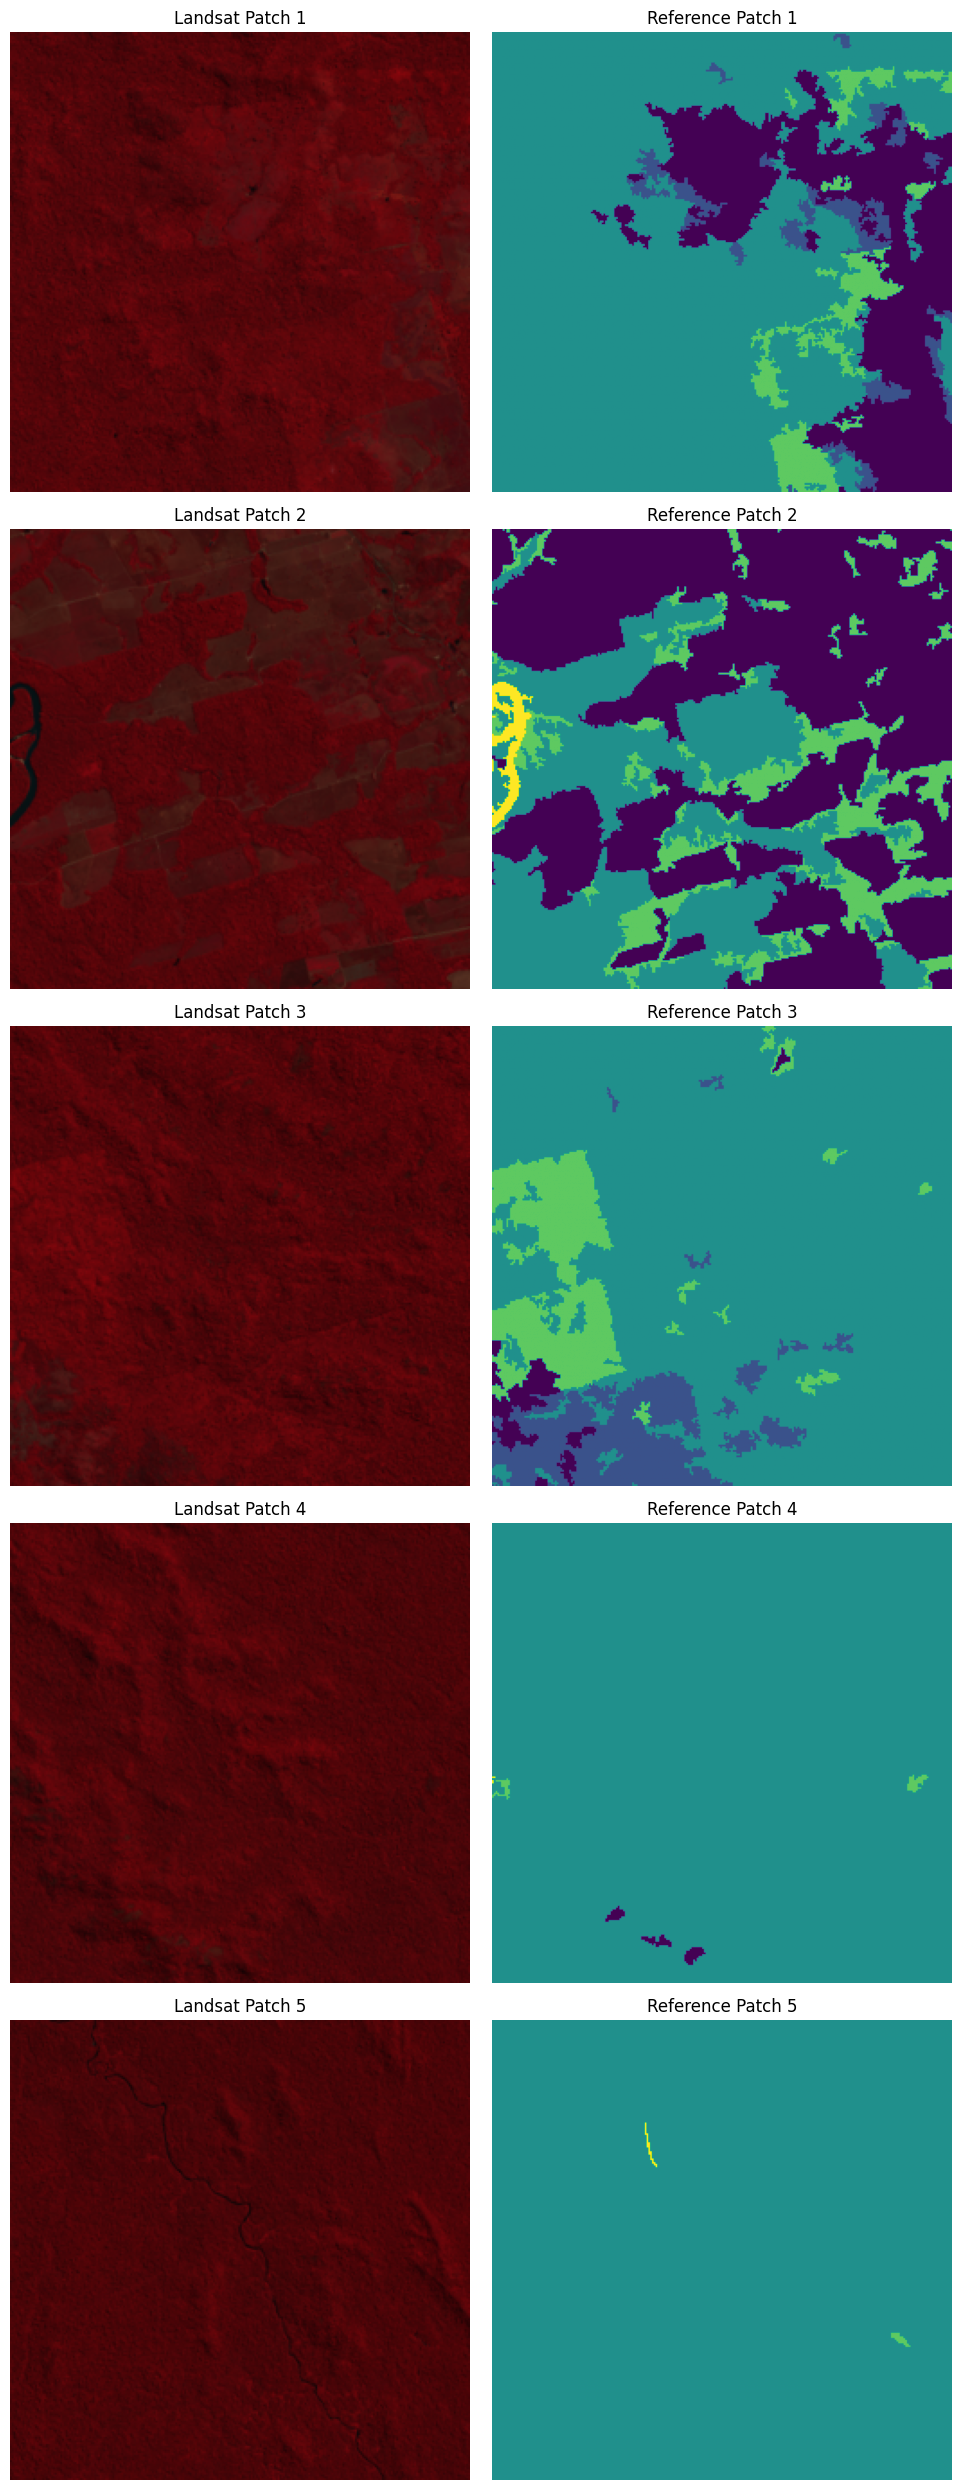

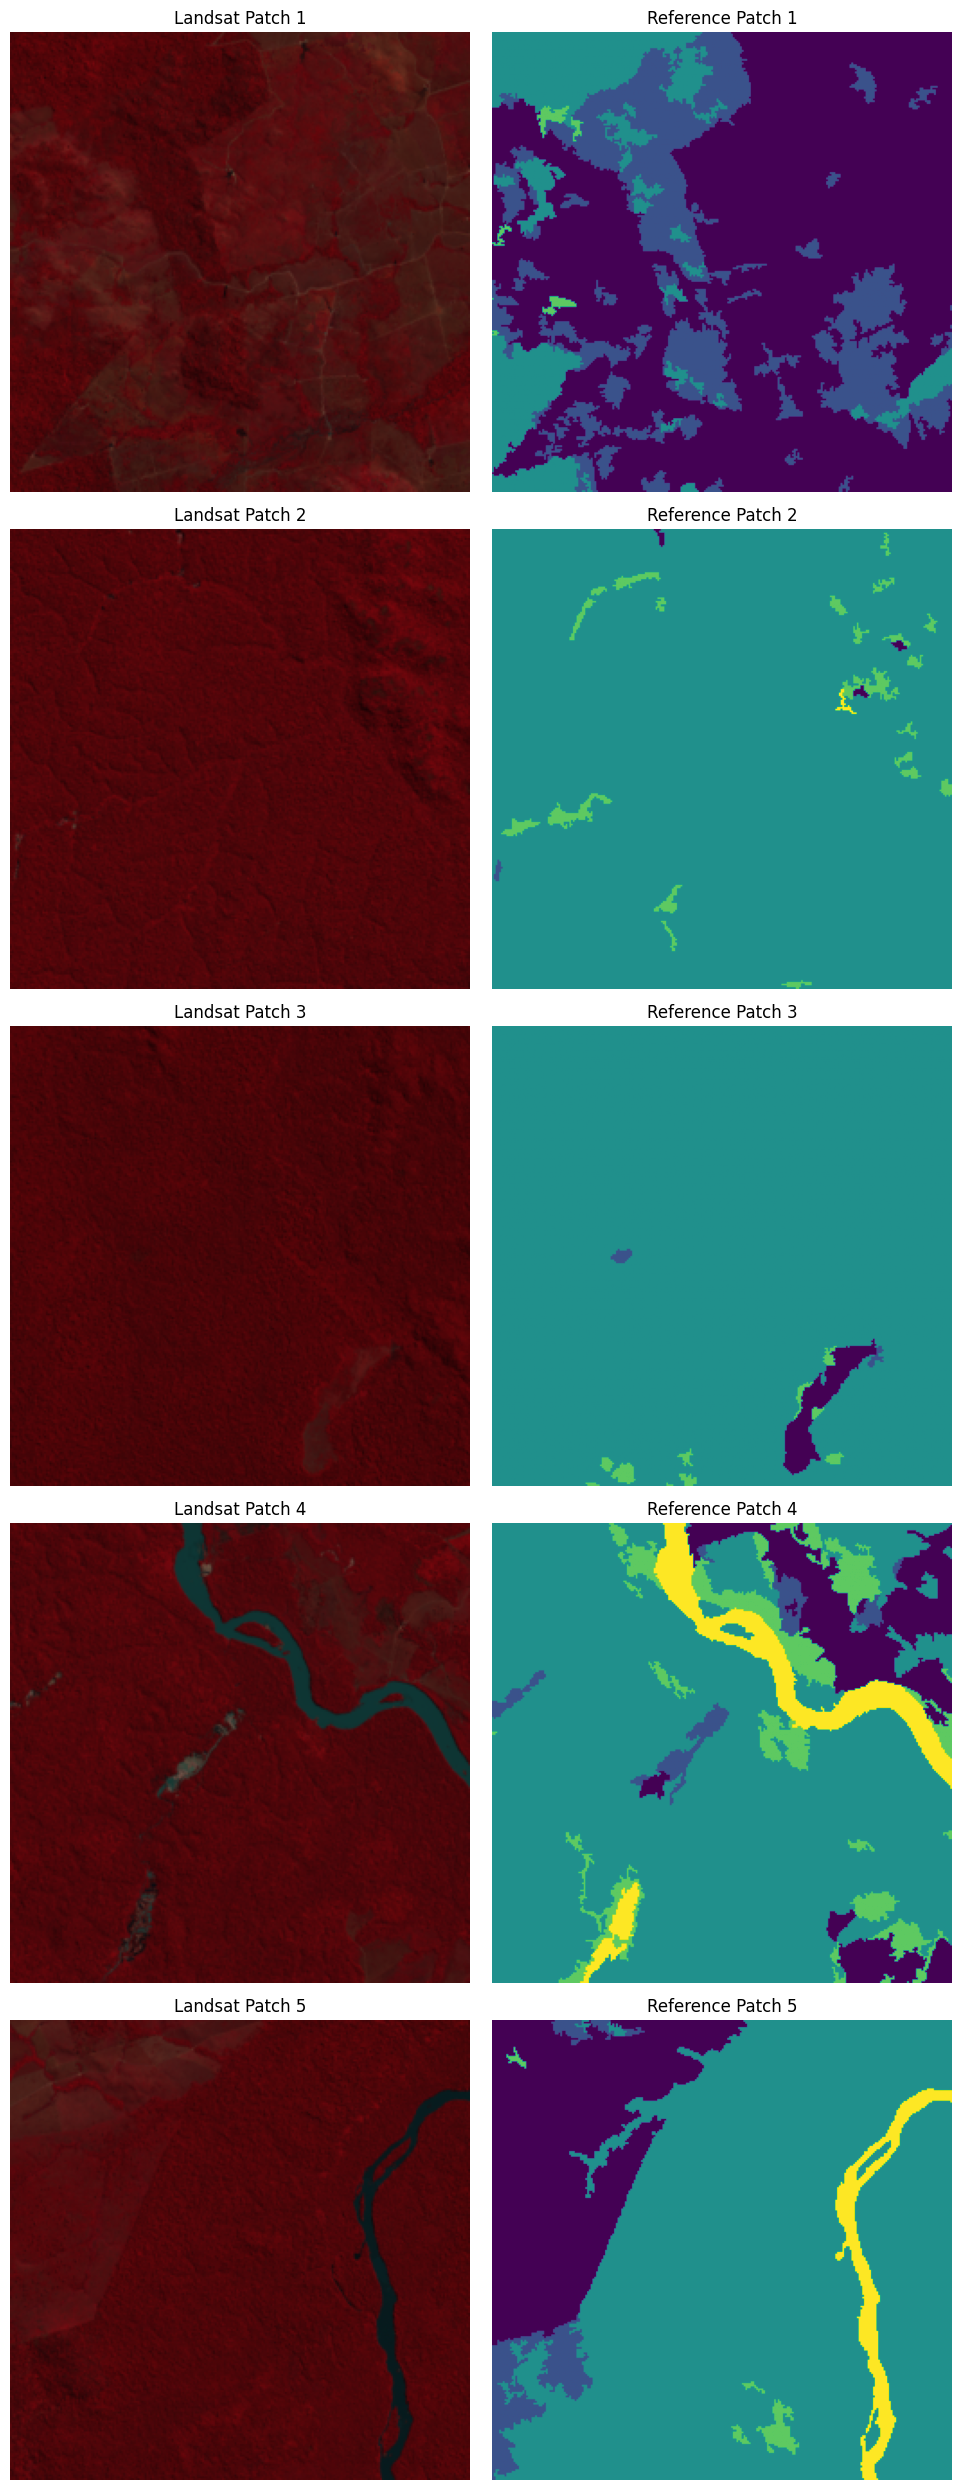

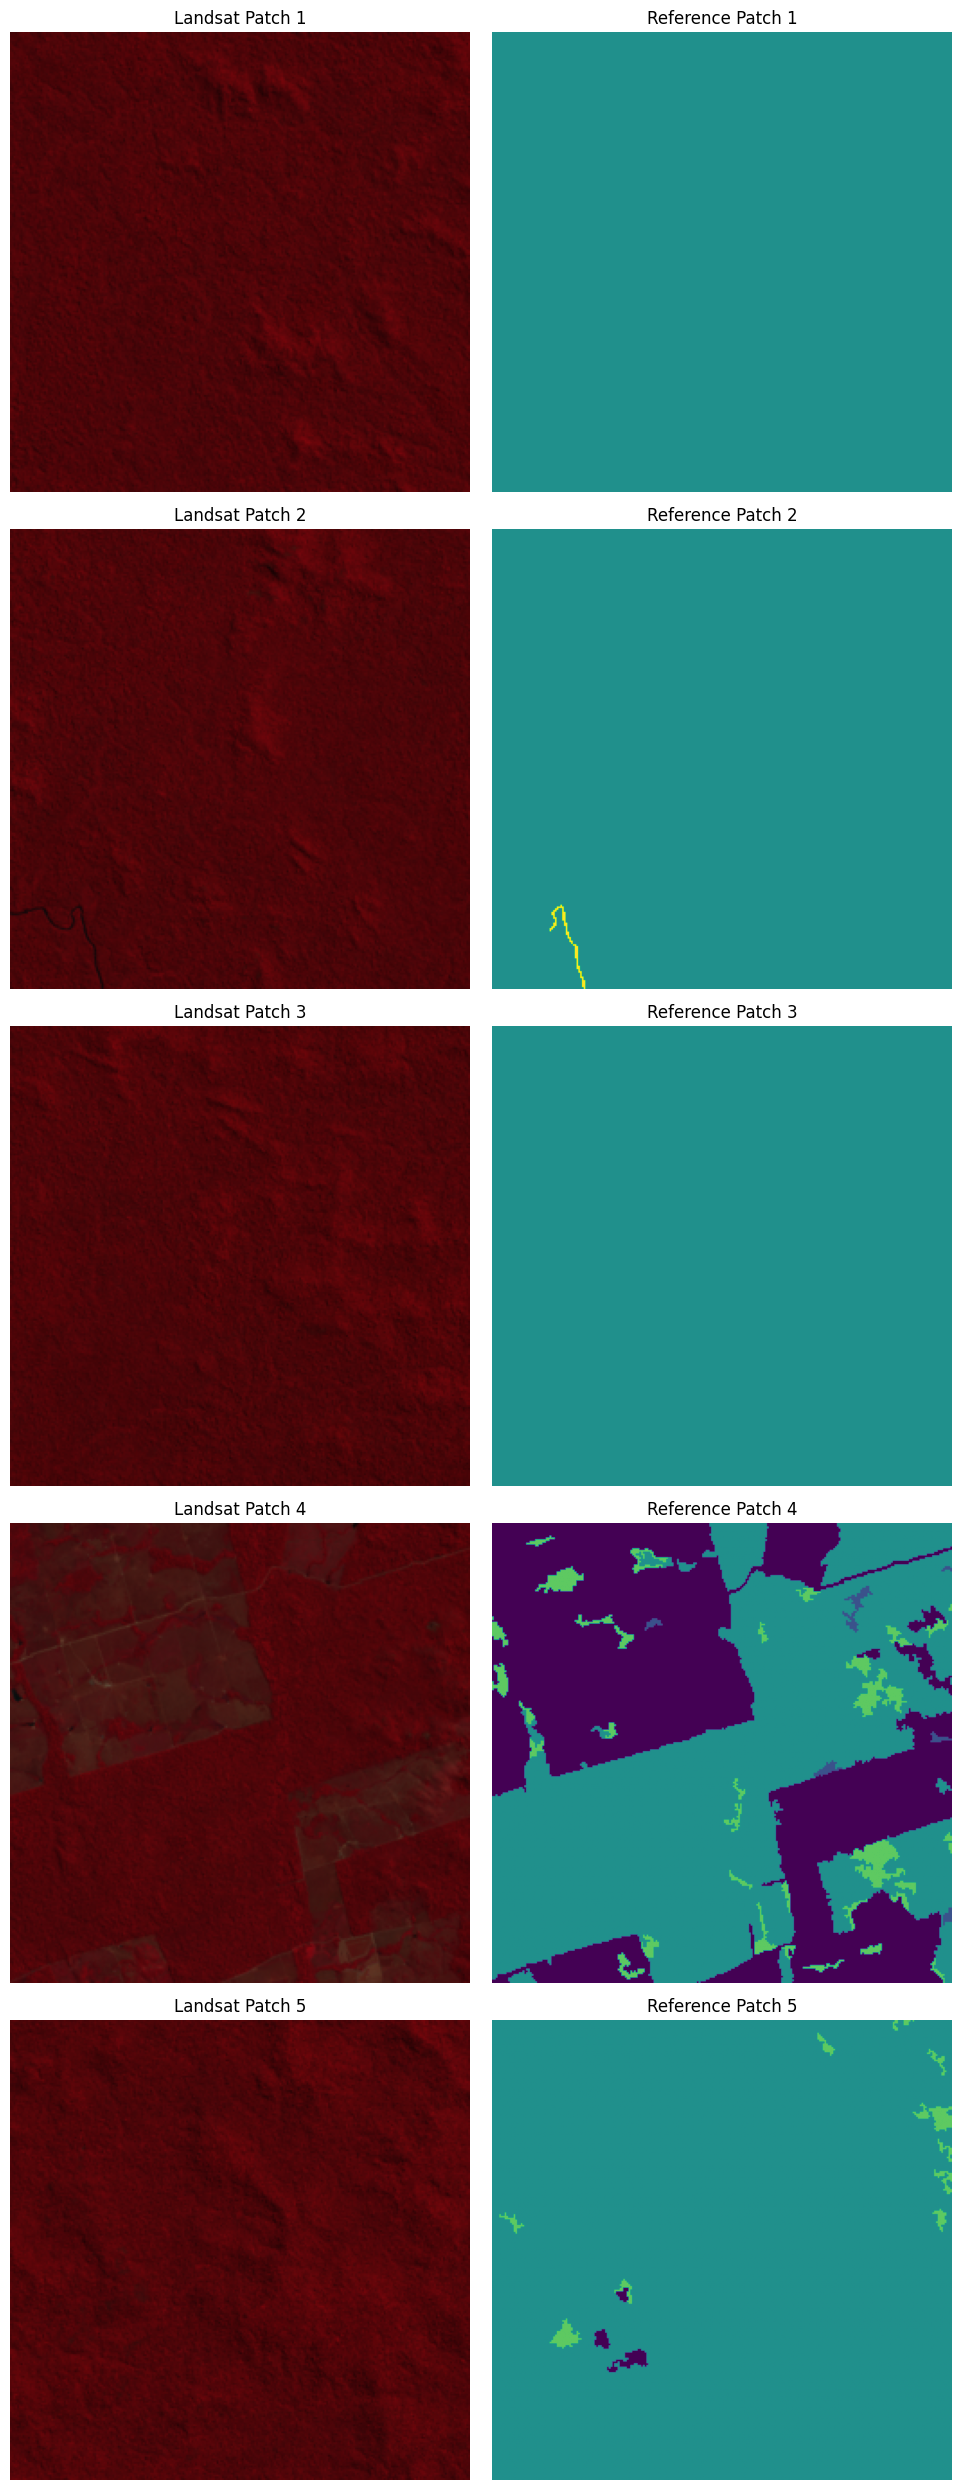

In [13]:
# Plotting function for visualization
def plot_patches(landsat_patches, reference_patches, num_patches=5):
    fig, axes = plt.subplots(num_patches, 2, figsize=(10, 5 * num_patches))
    for i in range(num_patches):
        # Plot Landsat patch
        ax = axes[i, 0]
        landsat_patch = landsat_patches[i]
        if landsat_patch.shape[2] == 5:
            landsat_patch_rgb = landsat_patch[:, :, [3, 2, 1]]  # Using bands 4, 3, 2 for RGB
            ax.imshow(landsat_patch_rgb)
        else:
            ax.imshow(landsat_patch, cmap='gray')
        ax.set_title(f'Landsat Patch {i+1}')
        ax.axis('off')

        # Plot Reference patch
        ax = axes[i, 1]
        reference_patch = reference_patches[i]
        reference_patch = reference_patch.squeeze()
        ax.imshow(reference_patch, cmap='viridis', vmin=0, vmax=4)
        ax.set_title(f'Reference Patch {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for training data
plot_patches(X_train, y_train, num_patches=5)

# Example usage for validation data
plot_patches(X_val, y_val, num_patches=5)

# Example usage for test data
plot_patches(X_test, y_test, num_patches=5)
